# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [94]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [131]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier 

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [132]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [133]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [134]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [135]:
df.tail()

,gender,age,income,family_members,insurance_benefits
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0
4999,1,28.0,40600.0,1,0


In [136]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2959,1,35.0,37100.0,1,0
3389,1,28.0,42000.0,1,0
1144,1,40.0,41800.0,2,0
3643,0,32.0,43600.0,0,0
3723,0,37.0,41500.0,3,0
465,0,46.0,49500.0,0,1
2570,1,31.0,59500.0,2,0
2374,1,20.0,32600.0,0,0
4082,0,36.0,26700.0,2,0
4055,1,19.0,34800.0,0,0


Our df consist of 4 continous and 1 categorical feature columns. 

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Let's see if we have Nans:

In [138]:
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

Let's check for duplicates:


In [139]:
df.duplicated().value_counts()

False    4847
True      153
dtype: int64

There are 153 duplicates but since we have no IDs and only 5 features, it is logical to assume that we will have some duplicates in a dataset of 5000 instances. Therefore we decided not to drop them. 

In [140]:
# we may want to fix the age type (from float to int) though this is not critical

df.age = df.age.astype(int)

In [141]:
# check to see that the conversion was successful

In [142]:
df.age.dtype

dtype('int64')

In [143]:
# now have a look at the data's descriptive statistics. 
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Let's visualise the data

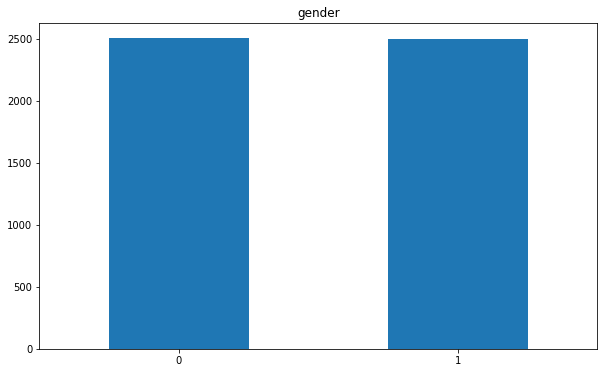

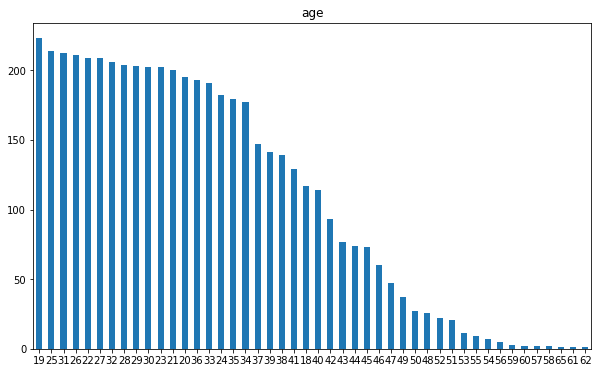

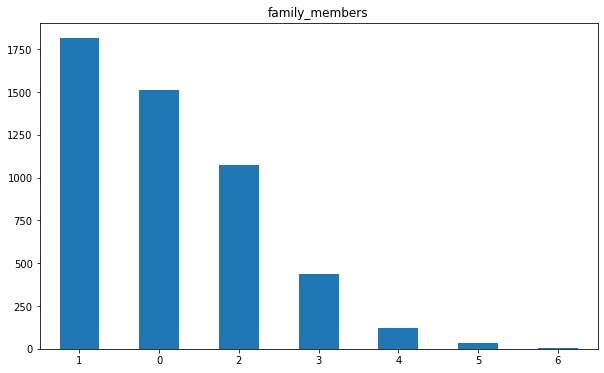

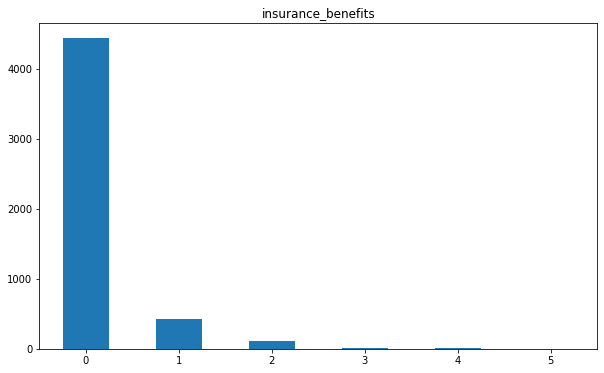

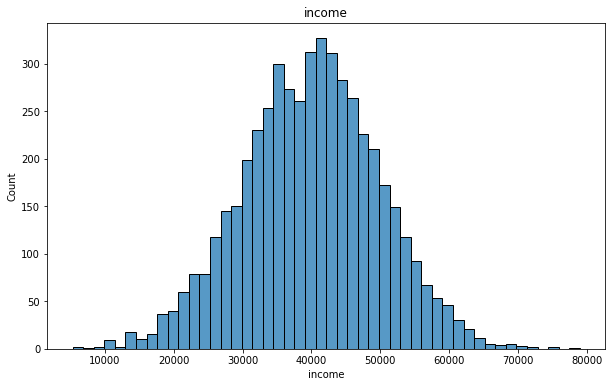

In [144]:
countplot = ['gender', 'age', 'family_members', 'insurance_benefits']
hist = ['income']

for col in countplot:
    values = df[col].value_counts()
    plt.figure(figsize=(10,6))
    values.plot(kind = 'bar')
    plt.xticks(rotation=0)
    plt.title(col)
    
for col in hist:
    plt.figure(figsize=(10,6))
    sns.histplot(df[col])
    plt.title(col) 


* There's an equal share of men and women in our dataset.
* Most of our clients between 19 and 40 years of age.
* Most of them have 1 family members or don't have a family member at all.
* Vast majority never recieved any insurance benefits.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, the data was loaded and inspected!

</div>

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

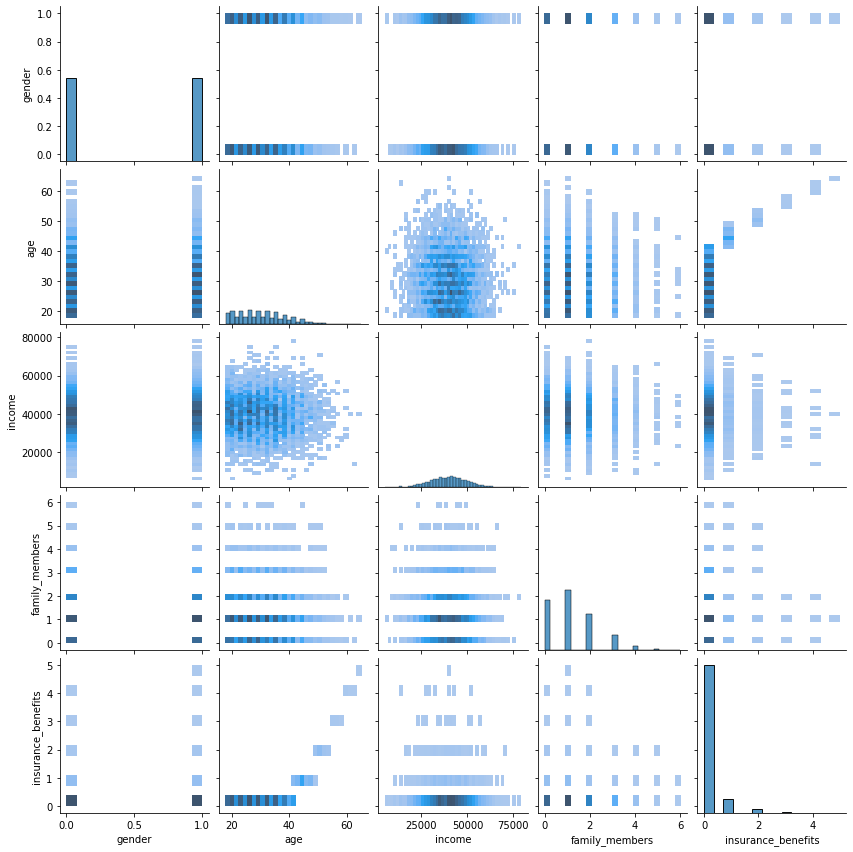

In [145]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [146]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [147]:
from sklearn.neighbors import NearestNeighbors

def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=1)
    nbrs.fit(df[feature_names].to_numpy())
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

<div class="alert alert-success">
<b>Reviewer's comment</b>

The code for getting nearest neighbors is correct

</div>

Scaling the data.

In [148]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [149]:
df_scaled.sample(5)


,gender,age,income,family_members,insurance_benefits
279,0.0,0.353846,0.437975,0.500000,0
2146,1.0,0.646154,0.410127,0.000000,1
2224,1.0,0.769231,0.341772,0.166667,2
3632,1.0,0.400000,0.573418,0.500000,0
892,1.0,0.415385,0.541772,0.333333,0


Now, let's get similar records for a given one for every combination

In [150]:
get_knn(df, 5, 8, "euclidian")

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.000000
1995,0,45,41000.0,0,1,3.000000
4763,1,46,41000.0,1,1,3.162278
3801,0,46,41000.0,2,1,3.162278
3972,1,40,41000.0,1,0,3.162278
2759,0,47,41000.0,3,1,4.242641
2717,0,37,41000.0,0,0,6.403124
3434,1,36,41000.0,2,0,7.000000


In [151]:
get_knn(df_scaled, 5, 8, "euclidian") 

,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
1147,1.0,0.646154,0.516456,0.333333,0,0.015592
4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1019,1.0,0.646154,0.501266,0.333333,0,0.023468
2962,1.0,0.630769,0.520253,0.333333,0,0.030795
2128,1.0,0.692308,0.512658,0.333333,1,0.031413
106,1.0,0.692308,0.526582,0.333333,1,0.031693
2206,1.0,0.692308,0.530380,0.333333,1,0.032811


In [152]:
get_knn(df_scaled, 5, 8, "manhattan") 

,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
1147,1.0,0.646154,0.516456,0.333333,0,0.015592
4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1019,1.0,0.646154,0.501266,0.333333,0,0.023468
2962,1.0,0.630769,0.520253,0.333333,0,0.030795
2128,1.0,0.692308,0.512658,0.333333,1,0.031413
106,1.0,0.692308,0.526582,0.333333,1,0.031693
2206,1.0,0.692308,0.530380,0.333333,1,0.032811


In [153]:
get_knn(df, 5, 8, "manhattan") 

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.000000
1995,0,45,41000.0,0,1,3.000000
4763,1,46,41000.0,1,1,3.162278
3801,0,46,41000.0,2,1,3.162278
3972,1,40,41000.0,1,0,3.162278
2759,0,47,41000.0,3,1,4.242641
2717,0,37,41000.0,0,0,6.403124
3434,1,36,41000.0,2,0,7.000000


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Scalled and non scalled datasets output different results (different neighbors and therefore different distances to the neighbors). The non scalled dataset will asign a greater "importance" to the column with a greater values (in our case - "income" column) and lesser value to the other columns with relativeluy smaller values (for example "family_members" column).

We can see the effect on the instances that the function picks: Scalled and non scalled datasets result in totally different neighbors. In fact, in our specific case of looking for the kneighbors of instance number 5, there's not even one common neighbor between the two scenarios.  

This, once again, stresses the importance of data normalization. 

In [154]:
# Comparing the neigbors (scaled vs non scaled)
get_knn(df, 5, 8, "euclidian").index == get_knn(df_scaled, 5, 8, "euclidian").index

array([ True, False, False, False, False, False, False, False])

The comparison above shows that all the neigbors chosen using scaled/non scaled datasets, are different. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The Manhattan distance metric results, in our specific case (of looking for the kneighbors of instance number 5), are identical to the euclidian metric, for both scaling methods. Meaning that the function that uses Manhattan metric chooses the same neighbors as the euclidian metric as long as we use the same scaling method (scaled or non scaled.) The distances are also identical. 

In [155]:
# Comparing the neighbors:
get_knn(df_scaled, 5, 8, "manhattan").index == get_knn(df_scaled, 5, 8, "euclidian").index

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [156]:
# Comparing the distances
get_knn(df_scaled, 5, 8, "manhattan")["distance"] == get_knn(df_scaled, 5, 8, "euclidian")["distance"] 

5       True
1147    True
4074    True
1019    True
2962    True
2128    True
106     True
2206    True
Name: distance, dtype: bool

<div class="alert alert-success">
<b>Reviewer's comment</b>

The answers make sense, well done!

</div>

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [157]:
# calculate the target

df['insurance_benefits_received'] =[0 if x== 0 else 1 for x in df["insurance_benefits"]]


<div class="alert alert-success">
<b>Reviewer's comment</b>

Correct!

</div>

In [158]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [159]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [160]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

**Scaled df**

In [161]:

X_train, X_val, y_train, y_val = train_test_split(df_scaled[feature_names],df['insurance_benefits_received'],test_size = 0.3 )

In [162]:
for k in range(1,10):
    print("Calculating for", k, "neighbors")
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    eval_classifier(y_val, y_pred)

    print(" ")

Calculating for 1 neighbors
F1: 0.93
Confusion Matrix
[[0.88133333 0.00933333]
 [0.00533333 0.104     ]]
 
Calculating for 2 neighbors
F1: 0.90
Confusion Matrix
[[0.886      0.00466667]
 [0.016      0.09333333]]
 
Calculating for 3 neighbors
F1: 0.90
Confusion Matrix
[[0.88266667 0.008     ]
 [0.01266667 0.09666667]]
 
Calculating for 4 neighbors
F1: 0.88
Confusion Matrix
[[0.88533333 0.00533333]
 [0.02       0.08933333]]
 
Calculating for 5 neighbors
F1: 0.89
Confusion Matrix
[[0.882      0.00866667]
 [0.01533333 0.094     ]]
 
Calculating for 6 neighbors
F1: 0.88
Confusion Matrix
[[0.88533333 0.00533333]
 [0.01933333 0.09      ]]
 
Calculating for 7 neighbors
F1: 0.90
Confusion Matrix
[[0.88533333 0.00533333]
 [0.01466667 0.09466667]]
 
Calculating for 8 neighbors
F1: 0.90
Confusion Matrix
[[0.88733333 0.00333333]
 [0.018      0.09133333]]
 
Calculating for 9 neighbors
F1: 0.91
Confusion Matrix
[[0.88666667 0.004     ]
 [0.014      0.09533333]]
 


**Non Scaled df**

In [163]:
X_train, X_val, y_train, y_val = train_test_split(df[feature_names],df['insurance_benefits_received'],test_size = 0.3 )


In [164]:
for k in range(1,10):
    print("Calculating for", k, "neighbors")
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    eval_classifier(y_val, y_pred)

    print(" ")

Calculating for 1 neighbors
F1: 0.64
Confusion Matrix
[[0.874      0.01866667]
 [0.04866667 0.05866667]]
 
Calculating for 2 neighbors
F1: 0.44
Confusion Matrix
[[0.88933333 0.00333333]
 [0.076      0.03133333]]
 
Calculating for 3 neighbors
F1: 0.45
Confusion Matrix
[[0.88       0.01266667]
 [0.072      0.03533333]]
 
Calculating for 4 neighbors
F1: 0.24
Confusion Matrix
[[8.92000000e-01 6.66666667e-04]
 [9.26666667e-02 1.46666667e-02]]
 
Calculating for 5 neighbors
F1: 0.24
Confusion Matrix
[[0.89       0.00266667]
 [0.092      0.01533333]]
 
Calculating for 6 neighbors
F1: 0.11
Confusion Matrix
[[8.92000000e-01 6.66666667e-04]
 [1.01333333e-01 6.00000000e-03]]
 
Calculating for 7 neighbors
F1: 0.11
Confusion Matrix
[[0.88666667 0.006     ]
 [0.10066667 0.00666667]]
 
Calculating for 8 neighbors
F1: 0.06
Confusion Matrix
[[8.92000000e-01 6.66666667e-04]
 [1.04000000e-01 3.33333333e-03]]
 
Calculating for 9 neighbors
F1: 0.07
Confusion Matrix
[[8.92000000e-01 6.66666667e-04]
 [1.03333

In [165]:
# Let's calculate the probability of paying any insurance benefit 
s = len(df[df["insurance_benefits_received"] ==1])

for P in [0, s/len(df["insurance_benefits_received"]), 0.5, 1]:
    print(rnd_model_predict(P, len(df["insurance_benefits_received"])))
    print("There are", np.count_nonzero(rnd_model_predict(P, len(df["insurance_benefits_received"]))), "ones in the vector above.")
    print(" ")


[0 0 0 ... 0 0 0]
There are 0 ones in the vector above.
 
[0 0 0 ... 0 0 0]
There are 546 ones in the vector above.
 
[1 0 1 ... 0 0 1]
There are 2455 ones in the vector above.
 
[1 1 1 ... 1 1 1]
There are 5000 ones in the vector above.
 


<div class="alert alert-success">
<b>Reviewer's comment</b>

kNN was applied to a classification problem successfully!

</div>

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [166]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) # <your code here>

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) # <your code here>
        y_pred = X2.dot(self.weights) # <your code here>
        
        return y_pred

<div class="alert alert-success">
<b>Reviewer's comment</b>

Linear regression was implemented correctly

</div>

In [167]:
import math
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

**Original Data**

In [168]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


**Scaled Data**

In [169]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


The metrics of RMSE and R2 before and after scaling are identical. Meaning that although the numerical representations have changed, the relationship between them remained the same. The R2 is relatively low, and can be further improved by changing the hyperparameters. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good! Note that scaling can make a difference if we apply L1 or L2 regularization or if we use a different method to train the model (e.g. stochastic gradient descent instead of normal equations)

</div>

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [170]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [171]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [172]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [173]:
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [174]:
print("Determinant:", np.linalg.det(P))
print("Shape:", P.shape)

Determinant: 0.24339135998015463
Shape: (4, 4)


* The matrix must be square (same number of rows and columns). 
* The determinant of the matrix must not be zero.

**Our matrix P fullfils both conditions.** Let's see if the invert of P returns an error.

In [175]:
np.linalg.inv(P)


array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

No error, meaning our P matrix is invertible

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yeah, it's actually very hard to generate a non-invertible matrix with float entries, because the subset of matrices with determinant equal to 0 has measure 0 in the set of all matrices.

</div>

Can you guess the customers' ages or income after the transformation?

In [176]:
obfus_df = X@P
obfus_df

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

No, it is not possible to guess the customers' ages or income after the transformation.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [177]:
for id in [1,2,3]:
    print("Original X :", X[id])
    print("The transformed X", (X@P)[id])
    print("Reversed data:", (obfus_df @ np.linalg.inv(P))[id]    )
    print(" ")

Original X : [0.0e+00 4.6e+01 3.8e+04 1.0e+00]
The transformed X [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
Reversed data: [1.679528e-12 4.600000e+01 3.800000e+04 1.000000e+00]
 
Original X : [    0.    29. 21000.     0.]
The transformed X [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
Reversed data: [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]
 
Original X : [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
The transformed X [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
Reversed data: [-1.0890777e-12  2.1000000e+01  4.1700000e+04  2.0000000e+00]
 


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The minuscule differences are the result of python's rounding error. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yeah, pretty much

</div>

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The formula of $w_p$ ($w$ obfuscated by matrix $P$) is

$$w_P = [(XP)^T XP]^{-1} (XP)^Ty
$$

It's simplified form (full calculation bellow) would be 
$$w_p= P^{-1}(X^TX)^{-1}X^Ty$$ 

while 
$$w = (X^T X)^{-1} X^T y $$

Meaning the weights are linked via invertible matrix $P$.
Because the values are obfuscated with matrix $P$, when calculating the prediction $\hat{y}$, we actually multiplying the matrix $P$ with its inverse matrix $p^{-1}$, which results in the unit matrix $I$. Thus we are left with exactly the same $X_v$, $(X^TX)^{-1}$, $X^T$, and $\hat{y}$ just like in the original formula for the original data.

**Analytical proof:**:

let's simplify the $w_p$:

$$w_P = [(XP)^T XP]^{-1} P^TX^Ty
$$
$$w_P = [P^TX^TXP]^{-1} P^TX^Ty
$$
$$w_P = P^{-1}(X^TX)^{-1} (P^T)^{-1}P^TX^Ty
$$
$$w_P = P^{-1}(X^TX)^{-1}IX^Ty$$
$$w_p= P^{-1}(X^TX)^{-1}X^Ty$$


we already know that 
$$\hat{y} = X_vw$$

We can replace the $w$ with the the full formula and get:

$$\hat{y} = X_v(X^TX)^{-1}X^Ty$$

With simplified $w_p$ and obfuscated values the result would be:

$$\hat{y} = X_vPP^{-1}(X^TX)^{-1}X^Ty$$

multiplying the matrix $P$ with its inverse matrix $p^{-1}$ results in the unit matrix $I$.

$$\hat{y} = X_vI(X^TX)^{-1}X^Ty$$

$$\hat{y} = X_v(X^TX)^{-1}X^Ty$$

We see that the $\hat{y}$ for the original data and the obfuscated data is the same.

What does that mean for the quality of linear regression if you measure it with RMSE?

The RMSE results will not change, since we have the same predictions. The variables that the RMSE metric is calculated by them (the predictions and the target variable) didn't change, so the RMSE metric also wouldn't change. Meaning that the linear regression algorithm will continue to give accurate predictions, regardless of the obfuscation.

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great, now the proof is correct, well done!

</div>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [178]:
# Splitting data into features and target
X = df.drop(columns=['insurance_benefits', "insurance_benefits_received"])
y = df['insurance_benefits']

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Ok!

</div>

In [179]:
# Creating a random matrix X
rng = np.random.default_rng(seed=12)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [180]:
# Checking that our P matrix is np.linalg.inv(P)
print(np.linalg.inv(P))
print("Determinant:", np.linalg.det(P))
print("Shape:", P.shape)

[[-0.93192715  1.02484747  1.12334779 -1.23255562]
 [ 1.4103258  -0.28993985 -0.26093133 -0.17240947]
 [ 0.12035908  1.2698597  -0.56583439  0.30569054]
 [-0.6930974  -1.24359406  0.4038029   2.31193908]]
Determinant: 0.1909965984971535
Shape: (4, 4)


**Original Dataset:**

In [181]:
# Splitting data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [182]:
# Model fitting
model = LinearRegression().fit(X_train, y_train)

preds = model.predict(X_test)
# Model test with R2 metric
r1_model1 = r2_score(y_test, preds)
RMSE_model1 = mean_squared_error(y_test, preds, squared=True)
print("R2:", r1_model1)
print("RMSE:", RMSE_model1)

R2: 0.4254778540696319
RMSE: 0.13862989572441412


**Obfuscated Dataset**

In [183]:
P

array([[0.25082446, 0.94675294, 0.18932038, 0.17929141],
       [0.34988924, 0.23054125, 0.67044574, 0.11507938],
       [0.89630937, 0.85813049, 0.00282703, 0.54146616],
       [0.10685127, 0.25795496, 0.41689604, 0.45361612]])

In [184]:
# Data transformation
X_t = df.drop(columns=['insurance_benefits', "insurance_benefits_received"]) @ P
X_t.head()

,0,1,2,3
0,44471.648070,42573.929158,168.315288,26862.072783
1,34075.957957,32619.821437,138.684623,20581.461413
2,18832.643636,18027.425967,78.810602,11374.126698
3,37383.662260,35789.398671,132.800395,22582.462843
4,23403.722377,22404.607673,92.747341,14135.668335


In [185]:
# Splitting data into train and test samples [our y remains the same!]
X_train, X_test, y_train, y_test = train_test_split(X_t, y, random_state=42)

In [186]:
# Model fitting
model_2 = LinearRegression().fit(X_train, y_train)

preds = model_2.predict(X_test)
# Model test with R2 metric
r2_model2 = r2_score(y_test, preds)
RMSE2_model2 = mean_squared_error(y_test, preds, squared=True)
print("R2 for Obfuscated Dataset:", r2_model2)
print("RMSE for Obfuscated Dataset:", RMSE2_model2)

R2 for Obfuscated Dataset: 0.4254778540686114
RMSE for Obfuscated Dataset: 0.13862989572466036


The differences in the results are minuscule

<div class="alert alert-success">
<b>Reviewer's comment</b>

Barring the data leakage problem, the experiment is conducted correctly

</div>

# Conclusions

* Scalling of the data drasticaly impacts the features and metrics (measures of error) of the LR models. 
* Scalled data performs much better than non scalled data. The error metrics are lower. 
* When it comes to the kneighbors classifcation, we did not discovered any difference between the euclidian measure of distance and the manhattan measure of distance. As long as the data is scalled identically, both euclidian and manhattan measures will pick the same instances (kneigbors)
* Obfuscating the data is a usefull tool for working with real world data while keeping the features "oscure". 
* We can shift real world data to and from  obfuscation (i.e. recover) using a random matrix of our choise. 
* Shifting the data will change the features but not the relationships between the features in LR model. As long as we use the same scaling method, our metrics of error will be the same.


<div class="alert alert-success">
<b>Reviewer's comment</b>

Conclusions look good

</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>